## Dataset & Model building


In [1]:
# ============================================================
# Imports
# ============================================================
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader


In [ ]:
# ============================================================
# Download and extract SKU-110K dataset
# ============================================================
'''
import os
import tarfile
import urllib.request

DATA_ROOT = "data"
SKU_DIR = os.path.join(DATA_ROOT, "SKU-110K")
ARCHIVE_PATH = os.path.join(DATA_ROOT, "SKU110K_fixed.tar.gz")

os.makedirs(DATA_ROOT, exist_ok=True)

URL = "http://trax-geometry.s3.amazonaws.com/cvpr_challenge/SKU110K_fixed.tar.gz"

# Download
if not os.path.exists(ARCHIVE_PATH):
    print("Downloading SKU-110K dataset...")
    urllib.request.urlretrieve(URL, ARCHIVE_PATH)
    print("Download completed.")
else:
    print("Archive already exists, skipping download.")

# Extract
if not os.path.exists(SKU_DIR):
    print("Extracting dataset...")
    with tarfile.open(ARCHIVE_PATH, "r:gz") as tar:
        tar.extractall(DATA_ROOT)
    os.rename(os.path.join(DATA_ROOT, "SKU110K_fixed"), SKU_DIR)
    print("Extraction completed.")
else:
    print("Dataset already extracted.")

print("\nDataset structure:")
for item in os.listdir(SKU_DIR):
    print(" -", item)
'''

In [ ]:
# ============================================================
# Paths
# ============================================================
DATA_ROOT = "dataset/SKU110K_fixed"
IMG_DIR   = os.path.join(DATA_ROOT, "images")
ANN_DIR   = os.path.join(DATA_ROOT, "annotations")

TRAIN_CSV = os.path.join(ANN_DIR, "annotations_train.csv")
VAL_CSV   = os.path.join(ANN_DIR, "annotations_val.csv")
TEST_CSV  = os.path.join(ANN_DIR, "annotations_test.csv")


In [ ]:
# ============================================================
# CSV column fix (NO HEADER IN FILE!)
# ============================================================
CSV_COLS = [
    "image_name",
    "x1", "y1", "x2", "y2",
    "class",
    "image_width",
    "image_height"
]

def load_annotations(csv_path):
    df = pd.read_csv(
        csv_path,
        header=None,
        names=CSV_COLS
    )
    return df

train_df = load_annotations(TRAIN_CSV)
val_df   = load_annotations(VAL_CSV)
test_df  = load_annotations(TEST_CSV)

print("Train rows:", len(train_df))
print("Unique train images:", train_df["image_name"].nunique())

train_df.head()


Train rows: 1208482
Unique train images: 8219


image_name    x1    y1    x2    y2   class  image_width  image_height
0  train_0.jpg   208   537   422   814  object         3024          3024
1  train_0.jpg  1268  1923  1365  2209  object         3024          3024
2  train_0.jpg  1135  2074  1261  2166  object         3024          3024
3  train_0.jpg  1045  2085  1122  2258  object         3024          3024
4  train_0.jpg   976  2036  1040  2177  object         3024          3024

In [ ]:
class SKU110KQuickDataset(Dataset):
    def __init__(self, image_dir, df, img_size=512):
        self.image_dir = image_dir
        self.df = df
        self.img_size = img_size
        self.images = df["image_name"].unique()
        self.groups = df.groupby("image_name")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)

        img = cv2.imread(img_path)
        if img is None:
            raise RuntimeError(f"Failed to read image: {img_path}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        orig_h, orig_w = img.shape[:2]

        # Resize image
        img = cv2.resize(img, (self.img_size, self.img_size))

        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.0

        # --- FIX: scale boxes to resized image ---
        rows = self.groups.get_group(img_name)
        boxes = rows[["x1", "y1", "x2", "y2"]].values.astype(np.float32)

        scale_x = self.img_size / orig_w
        scale_y = self.img_size / orig_h

        boxes[:, [0, 2]] *= scale_x
        boxes[:, [1, 3]] *= scale_y

        boxes = torch.from_numpy(boxes)

        return {
            "image": img,
            "boxes": boxes,          # NOW IN RESIZED COORDS
            "image_name": img_name
        }


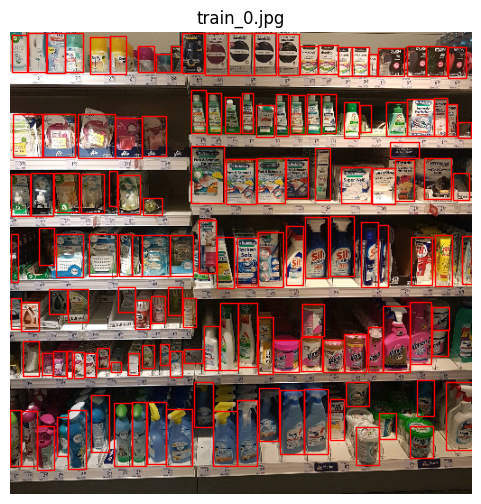

In [ ]:
# ============================================================
# Visual sanity check (CORRECT)
# ============================================================
img_size = 512
ds = SKU110KQuickDataset(IMG_DIR, train_df, img_size=img_size)

sample = ds[0]
img = sample["image"].permute(1, 2, 0).numpy()
boxes = sample["boxes"]

plt.figure(figsize=(6, 6))
plt.imshow(img)

for b in boxes:
    x1, y1, x2, y2 = b
    plt.gca().add_patch(
        plt.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            fill=False,
            edgecolor="red",
            linewidth=1
        )
    )

plt.title(sample["image_name"])
plt.axis("off")
plt.show()


In [ ]:
# ============================================================
# Collate function 
# ============================================================
def collate_fn_test(batch):
    images = torch.stack([b["image"] for b in batch], dim=0)

    targets = []
    for b in batch:
        num_boxes = b["boxes"].shape[0]

        targets.append({
            "boxes": b["boxes"],                     # (Ni, 4)
            "labels": torch.ones(num_boxes, dtype=torch.long)
        })

    return {
        "image": images,
        "targets": targets
    }





In [ ]:
# ============================================================
# DataLoader sanity check (should be instant)
# ============================================================
loader = DataLoader(
    ds,
    batch_size=4,
    shuffle=True,
    num_workers=0,   # IMPORTANT: start with 0
    collate_fn=collate_fn_test
)

batch = next(iter(loader))

print("Images:", batch["image"].shape)

for i, t in enumerate(batch["targets"]):
    print(f"Image {i}: boxes = {t['boxes'].shape}")


Images: torch.Size([4, 3, 512, 512])
Image 0: boxes = torch.Size([340, 4])
Image 1: boxes = torch.Size([185, 4])
Image 2: boxes = torch.Size([118, 4])
Image 3: boxes = torch.Size([119, 4])


In [2]:
# ============================================================
# Reproducibility & Device
# ============================================================
def seed_all(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, c: int, r: int = 16):
        super().__init__()
        mid = max(1, c // r)
        self.mlp = nn.Sequential(
            nn.Conv2d(c, mid, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid, c, 1, bias=False),
        )

    def forward(self, x):
        avg = torch.mean(x, dim=(2, 3), keepdim=True)
        mx = torch.amax(x, dim=(2, 3), keepdim=True)
        att = torch.sigmoid(self.mlp(avg) + self.mlp(mx))
        return x * att

class SpatialAttention(nn.Module):
    def __init__(self, k: int = 7):
        super().__init__()
        p = (k - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size=k, padding=p, bias=False)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        mx = torch.amax(x, dim=1, keepdim=True)
        att = torch.sigmoid(self.conv(torch.cat([avg, mx], dim=1)))
        return x * att

class CBAM(nn.Module):
    def __init__(self, c: int):
        super().__init__()
        self.ca = ChannelAttention(c)
        self.sa = SpatialAttention()

    def forward(self, x):
        return self.sa(self.ca(x))


In [ ]:
from torchvision import models

class ResNetBackboneCBAM(nn.Module):
    def __init__(self, name="resnet50", pretrained=True):
        super().__init__()

        weights = models.ResNet50_Weights.DEFAULT if pretrained else None
        base = models.resnet50(weights=weights)

        self.conv1 = base.conv1
        self.bn1 = base.bn1
        self.relu = base.relu
        self.maxpool = base.maxpool

        self.layer1 = base.layer1
        self.layer2 = base.layer2
        self.layer3 = base.layer3
        self.layer4 = base.layer4

        self.cbam2 = CBAM(256)
        self.cbam3 = CBAM(512)
        self.cbam4 = CBAM(1024)
        self.cbam5 = CBAM(2048)

        self.out_channels = (256, 512, 1024, 2048)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        c2 = self.cbam2(self.layer1(x))
        c3 = self.cbam3(self.layer2(c2))
        c4 = self.cbam4(self.layer3(c3))
        c5 = self.cbam5(self.layer4(c4))

        return {"c2": c2, "c3": c3, "c4": c4, "c5": c5}



In [ ]:
import torch.nn.functional as F


class FPN(nn.Module):
    def __init__(self, in_channels, fpn_channels=256):
        super().__init__()
        c2, c3, c4, c5 = in_channels
        self.l2 = nn.Conv2d(c2, fpn_channels, 1)
        self.l3 = nn.Conv2d(c3, fpn_channels, 1)
        self.l4 = nn.Conv2d(c4, fpn_channels, 1)
        self.l5 = nn.Conv2d(c5, fpn_channels, 1)

        self.s2 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.s3 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.s4 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.s5 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)

    def forward(self, feats):
        c2, c3, c4, c5 = feats.values()
        p5 = self.l5(c5)
        p4 = self.l4(c4) + F.interpolate(p5, size=c4.shape[-2:], mode="nearest")
        p3 = self.l3(c3) + F.interpolate(p4, size=c3.shape[-2:], mode="nearest")
        p2 = self.l2(c2) + F.interpolate(p3, size=c2.shape[-2:], mode="nearest")
        return {"p2": self.s2(p2), "p3": self.s3(p3), "p4": self.s4(p4), "p5": self.s5(p5)}

class ConvHead(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, out_ch, 1)
        )

    def forward(self, x):
        return self.net(x)

class ShelfScoutPanopticCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = ResNetBackboneCBAM()
        self.fpn = FPN(self.backbone.out_channels)

        self.sem_head = ConvHead(256, 2)
        self.ctr_head = ConvHead(256, 1)
        self.off_head = ConvHead(256, 2)

    def forward(self, x):
        feats = self.backbone(x)
        p2 = self.fpn(feats)["p2"]
        return self.sem_head(p2), self.ctr_head(p2), self.off_head(p2)


In [ ]:
# ============================================================
# Model
# ============================================================
model = ShelfScoutPanopticCNN().to(device)
print("Model loaded")


Model loaded


In [ ]:
# ============================================================
# Optimizer
# ============================================================
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,
    weight_decay=1e-4
)


In [ ]:
# ============================================================
# Forward sanity check
# ============================================================
model.eval()

batch = next(iter(loader))
imgs = batch["image"].to(device)

with torch.no_grad():
    sem_logits, ctr_logits, offsets = model(imgs)

print("sem_logits:", sem_logits.shape)
print("ctr_logits:", ctr_logits.shape)
print("offsets:", offsets.shape)


sem_logits: torch.Size([4, 2, 128, 128])
ctr_logits: torch.Size([4, 1, 128, 128])
offsets: torch.Size([4, 2, 128, 128])


In [ ]:
# ============================================================
# Target Generation Utilities
# ============================================================
import torch

STRIDE = 4  # feature stride (p2 level)

def build_targets_from_boxes(
    boxes: torch.Tensor,
    img_size: int,
    stride: int = STRIDE
):
    """
    boxes: Tensor [N,4] in original image coords (x1,y1,x2,y2)
    returns:
      sem_tgt  [Hf,Wf]
      ctr_tgt  [1,Hf,Wf]
      off_tgt  [2,Hf,Wf]
      off_mask [1,Hf,Wf]
    """
    Hf = img_size // stride
    Wf = img_size // stride

    sem_tgt  = torch.zeros((Hf, Wf), dtype=torch.long)
    ctr_tgt  = torch.zeros((1, Hf, Wf))
    off_tgt  = torch.zeros((2, Hf, Wf))
    off_mask = torch.zeros((1, Hf, Wf))

    for b in boxes:
        x1, y1, x2, y2 = b / stride

        x1 = int(torch.clamp(x1, 0, Wf-1))
        y1 = int(torch.clamp(y1, 0, Hf-1))
        x2 = int(torch.clamp(x2, 0, Wf-1))
        y2 = int(torch.clamp(y2, 0, Hf-1))

        if x2 <= x1 or y2 <= y1:
            continue

        # semantic mask
        sem_tgt[y1:y2, x1:x2] = 1

        # center
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        cx_i = int(cx)
        cy_i = int(cy)

        if 0 <= cx_i < Wf and 0 <= cy_i < Hf:
            ctr_tgt[0, cy_i, cx_i] = 1.0

        # offsets
        yy, xx = torch.meshgrid(
            torch.arange(y1, y2),
            torch.arange(x1, x2),
            indexing="ij"
        )

        off_tgt[0, yy, xx] = cx - xx
        off_tgt[1, yy, xx] = cy - yy
        off_mask[0, yy, xx] = 1.0

    return sem_tgt, ctr_tgt, off_tgt, off_mask


In [ ]:
# ============================================================
# Collate Function with Real Targets (FIXED)
# ============================================================
def collate_fn(batch):
    images = torch.stack([b["image"] for b in batch], dim=0)

    sem_tgts  = []
    ctr_tgts  = []
    off_tgts  = []
    off_masks = []

    # infer image size from tensor (safe & correct)
    img_size = images.shape[-1]

    for b in batch:
        sem, ctr, off, mask = build_targets_from_boxes(
            b["boxes"],
            img_size=img_size
        )
        sem_tgts.append(sem)
        ctr_tgts.append(ctr)
        off_tgts.append(off)
        off_masks.append(mask)

    return {
        "image": images,
        "sem_tgt": torch.stack(sem_tgts),
        "ctr_tgt": torch.stack(ctr_tgts),
        "off_tgt": torch.stack(off_tgts),
        "off_mask": torch.stack(off_masks)
    }



Image 0
  Objects (centers): 97
  Semantic pixels:   7246
  Offset pixels:     7246


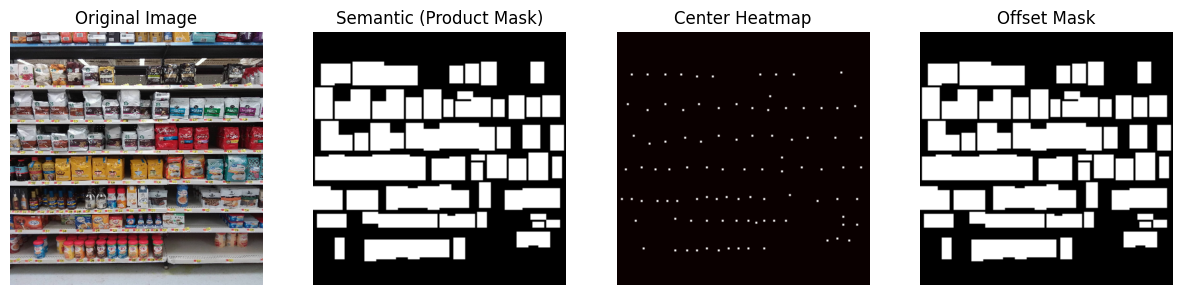


Image 1
  Objects (centers): 124
  Semantic pixels:   4909
  Offset pixels:     4909


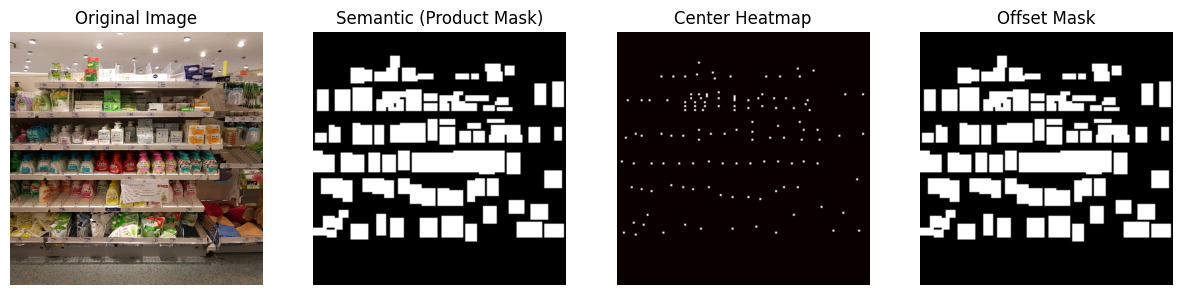


Image 2
  Objects (centers): 121
  Semantic pixels:   8015
  Offset pixels:     8015


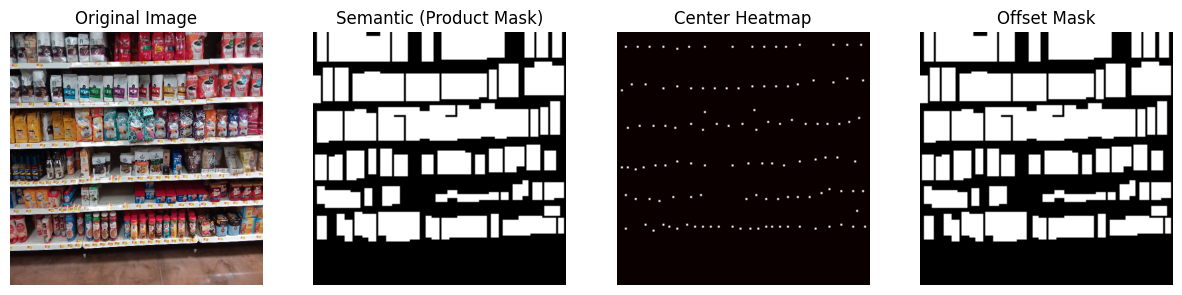


Image 3
  Objects (centers): 110
  Semantic pixels:   7034
  Offset pixels:     7034


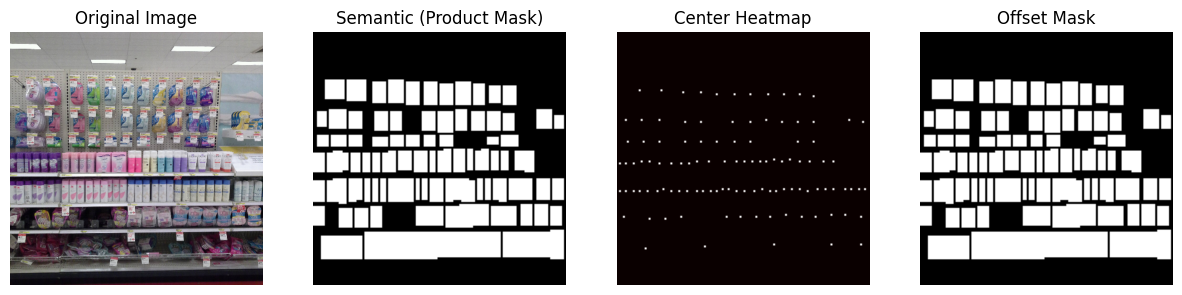

In [ ]:
# ============================================================
# Target Sanity Check
# ============================================================

loader = DataLoader(
    ds,
    batch_size=4,
    shuffle=True,
    num_workers=0,   # IMPORTANT: start with 0
    collate_fn=collate_fn
)

# ============================================================
# Target Sanity Check (DIAGNOSTIC)
# ============================================================
import matplotlib.pyplot as plt

batch = next(iter(loader))

B = batch["image"].shape[0]

for i in range(B):
    sem = batch["sem_tgt"][i]
    ctr = batch["ctr_tgt"][i][0]
    mask = batch["off_mask"][i][0]

    # Count objects = number of center peaks
    num_objects = int((ctr > 0.5).sum().item())

    # Count pixels labeled as product
    sem_pixels = int((sem > 0).sum().item())
    

    print(f"\nImage {i}")
    print(f"  Objects (centers): {num_objects}")
    print(f"  Semantic pixels:   {sem_pixels}")
    print(f"  Offset pixels:     {int(mask.sum().item())}")

    # ---- VISUALIZATION ----
    plt.figure(figsize=(15,4))

    plt.subplot(1,4,1)
    plt.imshow(batch["image"][i].permute(1,2,0))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(sem, cmap="gray")
    plt.title("Semantic (Product Mask)")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(ctr, cmap="hot")
    plt.title("Center Heatmap")
    plt.axis("off")

    plt.subplot(1,4,4)
    plt.imshow(mask, cmap="gray")
    plt.title("Offset Mask")
    plt.axis("off")

    plt.show()


In [ ]:
def dice_loss(logits: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6) -> torch.Tensor:
    probs = torch.softmax(logits, dim=1)[:, 1]
    targets = targets.float()
    num = 2 * (probs * targets).sum(dim=(1, 2)) + eps
    den = (probs + targets).sum(dim=(1, 2)) + eps
    return 1.0 - (num / den).mean()

def sigmoid_focal_loss(logits: torch.Tensor, targets: torch.Tensor,
                       alpha: float = 0.25, gamma: float = 2.0) -> torch.Tensor:
    p = torch.sigmoid(logits)
    ce = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce * ((1 - p_t) ** gamma)
    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss
    return loss.mean()

class ShelfScoutLoss(nn.Module):
    def __init__(self, w_sem=1.0, w_dice=0.5, w_ctr=1.0, w_off=1.0):
        super().__init__()
        self.w_sem = w_sem
        self.w_dice = w_dice
        self.w_ctr = w_ctr
        self.w_off = w_off
        self.ce = nn.CrossEntropyLoss()

    def forward(self, sem_logits, ctr_logits, offsets,
                sem_tgt, ctr_tgt, off_tgt, off_mask):

        l_sem = self.ce(sem_logits, sem_tgt)
        l_dice = dice_loss(sem_logits, sem_tgt)
        l_ctr = sigmoid_focal_loss(ctr_logits, ctr_tgt)

        diff = F.smooth_l1_loss(offsets, off_tgt, reduction="none")
        diff = diff * off_mask
        l_off = diff.sum() / (off_mask.sum() * 2.0 + 1e-6)

        total = (
            self.w_sem * l_sem +
            self.w_dice * l_dice +
            self.w_ctr * l_ctr +
            self.w_off * l_off
        )

        logs = {
            "l_sem": l_sem.item(),
            "l_dice": l_dice.item(),
            "l_ctr": l_ctr.item(),
            "l_off": l_off.item(),
            "total": total.item()
        }
        return total, logs


In [ ]:

def save_checkpoint(
    model,
    optimizer,
    epoch,
    save_dir="checkpoints",
    filename="shelfscout_latest.pth",
    keep_backup=False
):
    os.makedirs(save_dir, exist_ok=True)

    ckpt = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
    }

    path = os.path.join(save_dir, filename)
    torch.save(ckpt, path)

    if keep_backup and epoch % 5 == 0:
        backup_path = os.path.join(save_dir, f"shelfscout_epoch{epoch}.pth")
        torch.save(ckpt, backup_path)
        print(f"[Backup] Saved extra copy → {backup_path}")

    print(f"[Checkpoint] Saved epoch {epoch}")


In [ ]:
# ============================================================
# REAL Training Loop (ShelfScoutLoss)
# ============================================================
from tqdm import tqdm

model.train()
criterion = ShelfScoutLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

num_epochs = 2
global_step = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    pbar = tqdm(loader, desc=f"Train {epoch+1}")
    for batch in pbar:
        img = batch["image"].to(device)
        sem_tgt = batch["sem_tgt"].to(device)
        ctr_tgt = batch["ctr_tgt"].to(device)
        off_tgt = batch["off_tgt"].to(device)
        off_mask = batch["off_mask"].to(device)

        sem_logits, ctr_logits, offsets = model(img)

        loss, logs = criterion(
            sem_logits, ctr_logits, offsets,
            sem_tgt, ctr_tgt, off_tgt, off_mask
        )

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        global_step += 1
        pbar.set_postfix({k: f"{v:.4f}" for k,v in logs.items()})



Epoch 1/2


Train 1: 100%|██████████| 2055/2055 [24:43<00:00,  1.39it/s, l_sem=0.2237, l_dice=0.1533, l_ctr=0.0024, l_off=0.2650, total=0.5678]



Epoch 2/2


Train 2: 100%|██████████| 2055/2055 [22:06<00:00,  1.55it/s, l_sem=0.2955, l_dice=0.2039, l_ctr=0.0026, l_off=0.4016, total=0.8016]


In [ ]:
num_epochs = 10
save_every = 1

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    model.train()

    pbar = tqdm(loader, desc=f"Train {epoch+1}")
    for batch in pbar:
        img = batch["image"].to(device)
        sem_tgt = batch["sem_tgt"].to(device)
        ctr_tgt = batch["ctr_tgt"].to(device)
        off_tgt = batch["off_tgt"].to(device)
        off_mask = batch["off_mask"].to(device)

        sem_logits, ctr_logits, offsets = model(img)

        loss, logs = criterion(
            sem_logits, ctr_logits, offsets,
            sem_tgt, ctr_tgt, off_tgt, off_mask
        )

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        pbar.set_postfix({k: f"{v:.4f}" for k, v in logs.items()})

    # 🔐 SAVE CHECKPOINT
    if (epoch + 1) % save_every == 0:
        save_checkpoint(
            model,
            optimizer,
            epoch=epoch + 1,
            keep_backup= True
        )



Epoch 1/10


Train 1: 100%|██████████| 2055/2055 [25:39<00:00,  1.33it/s, l_sem=0.3151, l_dice=0.2079, l_ctr=0.0031, l_off=0.5202, total=0.9423]


[Checkpoint] Saved epoch 1

Epoch 2/10


Train 2: 100%|██████████| 2055/2055 [22:27<00:00,  1.52it/s, l_sem=0.2368, l_dice=0.1368, l_ctr=0.0022, l_off=0.3046, total=0.6120]


[Checkpoint] Saved epoch 2

Epoch 3/10


Train 3: 100%|██████████| 2055/2055 [22:12<00:00,  1.54it/s, l_sem=0.2680, l_dice=0.1780, l_ctr=0.0028, l_off=0.4676, total=0.8274]


[Checkpoint] Saved epoch 3

Epoch 4/10


Train 4: 100%|██████████| 2055/2055 [21:39<00:00,  1.58it/s, l_sem=0.2613, l_dice=0.1681, l_ctr=0.0018, l_off=0.1598, total=0.5070]


[Checkpoint] Saved epoch 4

Epoch 5/10


Train 5: 100%|██████████| 2055/2055 [22:35<00:00,  1.52it/s, l_sem=0.2151, l_dice=0.1600, l_ctr=0.0020, l_off=0.4437, total=0.7407]


[Backup] Saved extra copy → checkpoints\shelfscout_epoch5.pth
[Checkpoint] Saved epoch 5

Epoch 6/10


Train 6: 100%|██████████| 2055/2055 [22:47<00:00,  1.50it/s, l_sem=0.1596, l_dice=0.2391, l_ctr=0.0026, l_off=0.2264, total=0.5082]


[Checkpoint] Saved epoch 6

Epoch 7/10


Train 7: 100%|██████████| 2055/2055 [22:34<00:00,  1.52it/s, l_sem=0.2428, l_dice=0.1623, l_ctr=0.0026, l_off=0.2675, total=0.5940]


[Checkpoint] Saved epoch 7

Epoch 8/10


Train 8: 100%|██████████| 2055/2055 [22:22<00:00,  1.53it/s, l_sem=0.2175, l_dice=0.1416, l_ctr=0.0022, l_off=0.2102, total=0.5007]


[Checkpoint] Saved epoch 8

Epoch 9/10


Train 9: 100%|██████████| 2055/2055 [25:04<00:00,  1.37it/s, l_sem=0.2343, l_dice=0.1540, l_ctr=0.0021, l_off=0.2216, total=0.5349]


[Checkpoint] Saved epoch 9

Epoch 10/10


Train 10: 100%|██████████| 2055/2055 [22:24<00:00,  1.53it/s, l_sem=0.2209, l_dice=0.1708, l_ctr=0.0017, l_off=0.1362, total=0.4442]


[Backup] Saved extra copy → checkpoints\shelfscout_epoch10.pth
[Checkpoint] Saved epoch 10


In [ ]:
# ============================================================
# Validation Dataset & Loader
# ============================================================
val_ds = SKU110KQuickDataset(
    image_dir=IMG_DIR,
    df=val_df,
    img_size=512
)

val_loader = DataLoader(
    val_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print("Validation samples:", len(val_ds))


Validation samples: 588


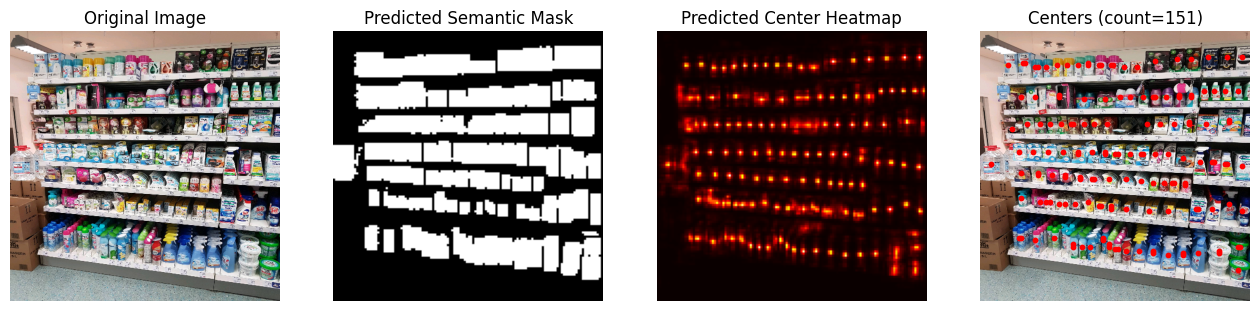

torch.Size([128, 128])
torch.Size([3, 512, 512])


In [ ]:
# ============================================================
# Inference / Prediction Visualization
# ============================================================
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()

@torch.no_grad()
def run_inference(sample):
    img = sample["image"].unsqueeze(0).to(device)

    sem_logits, ctr_logits, offsets = model(img)

    # semantic prediction
    sem_pred = torch.argmax(sem_logits, dim=1)[0].cpu()

    # center heatmap
    ctr_prob = torch.sigmoid(ctr_logits)[0,0].cpu()

    return sem_pred, ctr_prob


# ---- Pick a sample from TRAIN or VAL ----
sample = val_ds[3]   # you can change index

sem_pred, ctr_prob = run_inference(sample)

# ---- Visualize ----
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(sample["image"].permute(1,2,0))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(sem_pred, cmap="gray")
plt.title("Predicted Semantic Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(ctr_prob, cmap="hot")
plt.title("Predicted Center Heatmap")
plt.axis("off")
STRIDE = 4  # must match target generation

plt.subplot(1,4,4)
plt.imshow(sample["image"].permute(1,2,0))

ys, xs = torch.where(ctr_prob > 0.32)

# 🔥 scale feature coords -> image coords
xs_img = xs * STRIDE
ys_img = ys * STRIDE

plt.scatter(xs_img, ys_img, s=10, c="red")
plt.title(f"Centers (count={len(xs)})")
plt.axis("off")

plt.show()

print(ctr_prob.shape)
print(sample["image"].shape)

## Post-Processing & output Refining

In [ ]:
ckpt = torch.load("checkpoints/shelfscout_latest.pth", map_location=device)
model.load_state_dict(ckpt["model_state"])
optimizer.load_state_dict(ckpt["optimizer_state"])
start_epoch = ckpt["epoch"]


C:\Users\Mohammad\AppData\Local\Temp\ipykernel_11432\3031043575.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("checkpoints/shelfscout_latest.pth", ma

In [ ]:
# ============================================================
# Test Dataset & Loader
# ============================================================
test_ds = SKU110KQuickDataset(
    image_dir=IMG_DIR,
    df=test_df,
    img_size=512
)

test_loader = DataLoader(
    test_ds,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

print("Test samples:", len(test_ds))


Test samples: 2936


In [ ]:
# ============================================================
# Inference Setup (SAFE)
# ============================================================
model.eval()

batch = next(iter(loader))   # reuse training loader for now
img = batch["image"].to(device)   # [B,3,512,512] torch Tensor

with torch.no_grad():
    sem_logits, ctr_logits, offsets = model(img)

print("Image tensor:", img.shape)
print("Center logits:", ctr_logits.shape)


Image tensor: torch.Size([4, 3, 512, 512])
Center logits: torch.Size([4, 1, 128, 128])


In [ ]:
#============================================================
# Proper Center Decoding (NMS + Top-K)
#==========================================================

import torch
import torch.nn.functional as F

def decode_centers(
    ctr_logits: torch.Tensor,
    stride: int,
    prob_thresh: float = 0.3,
    nms_kernel: int = 3,
    top_k: int = 200
):
    """
    ctr_logits: [B, 1, Hf, Wf]
    stride: feature stride (e.g. 4)
    
    returns:
      List[List[Tensor]] — per image list of (x, y, score) in IMAGE coordinates
    """

    B, _, Hf, Wf = ctr_logits.shape
    device = ctr_logits.device

    # Sigmoid to probabilities
    ctr_probs = torch.sigmoid(ctr_logits)

    # -------- Local NMS (max pooling) --------
    pooled = F.max_pool2d(
        ctr_probs,
        kernel_size=nms_kernel,
        stride=1,
        padding=nms_kernel // 2
    )

    keep = (ctr_probs == pooled) & (ctr_probs > prob_thresh)

    decoded = []

    for b in range(B):
        ys, xs = torch.where(keep[b, 0])

        if len(xs) == 0:
            decoded.append([])
            continue

        scores = ctr_probs[b, 0, ys, xs]

        # -------- Top-K filtering --------
        if len(scores) > top_k:
            scores, idx = torch.topk(scores, top_k)
            xs = xs[idx]
            ys = ys[idx]

        # -------- Map to image coordinates --------
        centers = []
        for x, y, s in zip(xs, ys, scores):
            cx = (x.float() + 0.5) * stride
            cy = (y.float() + 0.5) * stride
            centers.append(torch.tensor([cx, cy, s], device=device))

        decoded.append(centers)

    return decoded


In [ ]:
model.eval()

with torch.no_grad():
    sem_logits, ctr_logits, offsets = model(img)

centers = decode_centers(
    ctr_logits,
    stride=STRIDE,
    prob_thresh=0.3,   # start here (much safer than 0.2)
    nms_kernel=3,
    top_k=150          # SKU110K rarely exceeds this
)

print(f"Predicted objects: {len(centers[0])}")


Predicted objects: 110


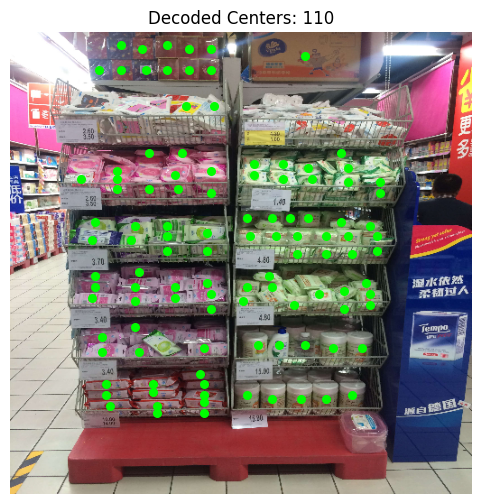

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.imshow(img[0].permute(1,2,0).cpu())
plt.axis("off")

for c in centers[0]:
    x, y, s = c
    plt.scatter(x.cpu(), y.cpu(), c="lime", s=30)

plt.title(f"Decoded Centers: {len(centers[0])}")
plt.show()


In [ ]:
# ============================================================
#  Counting Evaluation
# ============================================================
import math
import numpy as np

model.eval()

# --- get one evaluation batch ---
batch = next(iter(loader))

img = batch["image"].to(device)
gt_boxes = batch["sem_tgt"]          # semantic targets (for size reference)
gt_centers = batch["ctr_tgt"]        # GT centers (ground truth)

with torch.no_grad():
    sem_logits, ctr_logits, offsets = model(img)

# --- decode predicted centers ---
pred_centers = decode_centers(
    ctr_logits,
    stride=STRIDE,
    prob_thresh=0.29,
    nms_kernel=3,
    top_k=350
)

# ============================================================
# Per-image counting
# ============================================================
gt_counts = []
pred_counts = []

print("\nCounting diagnostics:\n")

B = img.shape[0]
for i in range(B):
    # Ground-truth count = number of GT center pixels
    gt_count = int((gt_centers[i] > 0.5).sum().item())
    pred_count = len(pred_centers[i])

    gt_counts.append(gt_count)
    pred_counts.append(pred_count)

    print(f"Image {i:02d} | GT: {gt_count:3d} | Pred: {pred_count:3d} | Diff: {pred_count - gt_count:+d}")

# ============================================================
# Dataset-level metrics
# ============================================================
gt_counts = np.array(gt_counts)
pred_counts = np.array(pred_counts)

mae  = np.mean(np.abs(pred_counts - gt_counts))
rmse = math.sqrt(np.mean((pred_counts - gt_counts) ** 2))
rel  = np.mean(np.abs(pred_counts - gt_counts) / (gt_counts + 1e-6)) * 100

print("\n--- Counting Metrics ---")
print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"Rel % error: {rel:.2f}%")



Counting diagnostics:

Image 00 | GT: 108 | Pred: 102 | Diff: -6
Image 01 | GT: 124 | Pred: 121 | Diff: -3
Image 02 | GT: 194 | Pred: 185 | Diff: -9
Image 03 | GT: 205 | Pred: 192 | Diff: -13

--- Counting Metrics ---
MAE : 7.75
RMSE: 8.59
Rel % error: 4.74%


In [ ]:
# ============================================================
# O.A Instance Reconstruction Utilities (RADIUS-GATED)
# ============================================================

import torch

def reconstruct_instances(
    sem_prob,
    ctr_points,
    offsets,
    sem_thresh=0.5,
    max_radius=16,     # <<< KEY FIX (feature-space pixels)
    min_pixels=12     # remove tiny noisy instances
):
    """
    sem_prob : [Hf, Wf]  semantic probability
    ctr_points : list of tensors [x,y] or [x,y,score]
    offsets : [2, Hf, Wf]
    """

    Hf, Wf = sem_prob.shape
    device = sem_prob.device

    if len(ctr_points) == 0:
        return torch.zeros((Hf, Wf), dtype=torch.int64)

    # ---- centers → tensor [K,2] in feature space ----
    centers = []
    for ctr in ctr_points:
        x, y = ctr[:2]
        centers.append([y // 4, x // 4])  # convert to feature coords

    centers = torch.tensor(centers, device=device).float()  # [K,2]

    # ---- pixel grid ----
    yy, xx = torch.meshgrid(
        torch.arange(Hf, device=device),
        torch.arange(Wf, device=device),
        indexing="ij"
    )
    coords = torch.stack([yy, xx], dim=-1).float()  # [Hf,Wf,2]

    # ---- apply offsets ----
    offsets = offsets.permute(1, 2, 0)  # [Hf,Wf,2]
    shifted = coords + offsets

    # ---- distance to centers ----
    dist = torch.cdist(
        shifted.view(-1, 2),
        centers
    )  # [Hf*Wf, K]

    min_dist, inst_ids = dist.min(dim=1)
    inst_ids = inst_ids.view(Hf, Wf) + 1

    # ---- RADIUS GATE (THE FIX) ----
    inst_ids[min_dist.view(Hf, Wf) > max_radius] = 0

    # ---- semantic gate ----
    instance_map = inst_ids * (sem_prob > sem_thresh)

    # ---- remove tiny instances ----
    for uid in instance_map.unique():
        if uid == 0:
            continue
        if (instance_map == uid).sum() < min_pixels:
            instance_map[instance_map == uid] = 0

    return instance_map



Image 0
GT objects (centers): 156
Predicted instances: 136


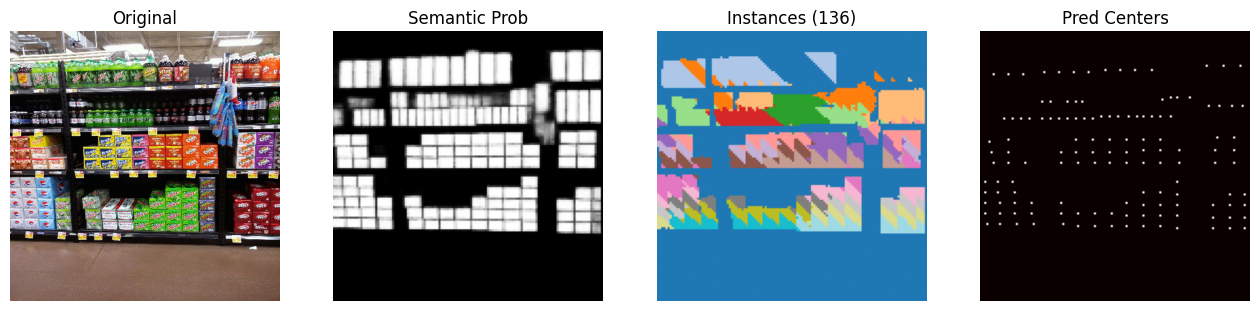


Image 1
GT objects (centers): 192
Predicted instances: 166


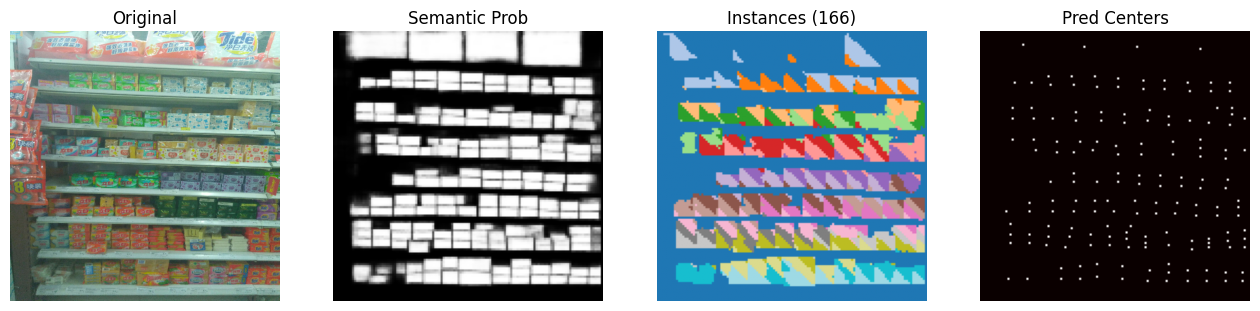


Image 2
GT objects (centers): 109
Predicted instances: 95


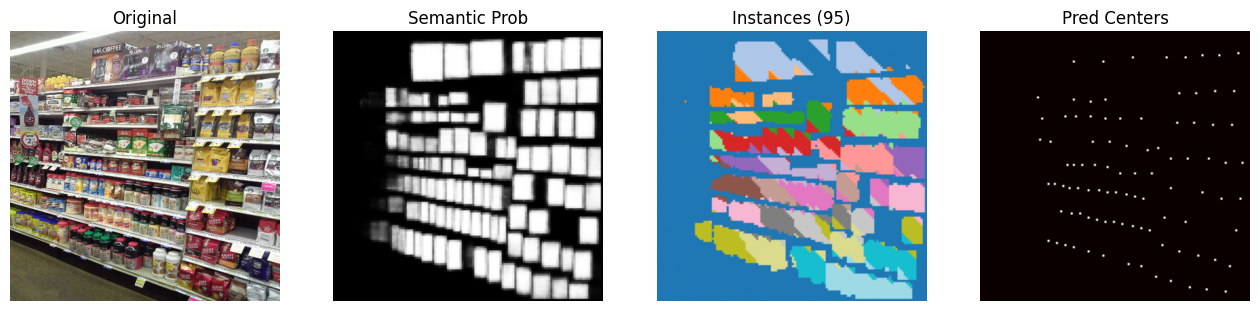


Image 3
GT objects (centers): 133
Predicted instances: 126


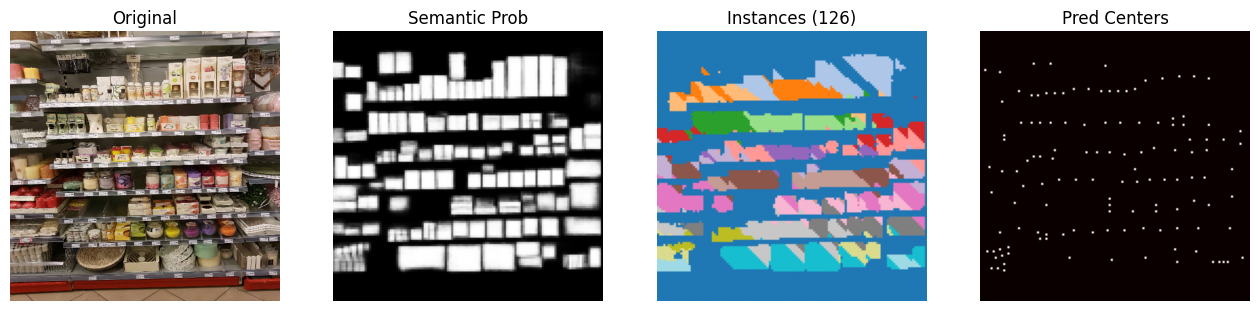

In [ ]:
# ============================================================
# O.A — Instance Reconstruction (Inference + Visualization)
# ============================================================

import matplotlib.pyplot as plt

model.eval()

batch = next(iter(loader))
img = batch["image"].to(device)

with torch.no_grad():
    sem_logits, ctr_logits, offsets = model(img)

centers = decode_centers(
    ctr_logits,
    stride=STRIDE,
    prob_thresh=0.29,
    nms_kernel=3,
    top_k=350
)

B = img.shape[0]

for i in range(B):
    sem_prob = torch.softmax(sem_logits[i], dim=0)[1]
    ctr_list = centers[i]
    off = offsets[i]

    instance_map = reconstruct_instances(
        sem_prob.cpu(),
        ctr_list,
        off.cpu(),
        sem_thresh=0.15
    )

    pred_instances = instance_map.unique().numel() - 1

    # -------- FIXED GT COUNT --------
    gt_centers = (batch["ctr_tgt"][i, 0] > 0.5).sum().item()

    print(f"\nImage {i}")
    print(f"GT objects (centers): {gt_centers}")
    print(f"Predicted instances: {pred_instances}")

    # -------- Visualization --------
    plt.figure(figsize=(16,4))

    plt.subplot(1,4,1)
    plt.imshow(img[i].cpu().permute(1,2,0))
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,4,2)
    plt.imshow(sem_prob.cpu(), cmap="gray")
    plt.title("Semantic Prob")
    plt.axis("off")

    plt.subplot(1,4,3)
    plt.imshow(instance_map, cmap="tab20")
    plt.title(f"Instances ({pred_instances})")
    plt.axis("off")

    plt.subplot(1,4,4)
    ctr_vis = torch.zeros_like(sem_prob)

    for ctr in ctr_list:
        x, y = ctr[:2]
        ctr_vis[int(y//4), int(x//4)] = 1

    plt.imshow(ctr_vis.cpu(), cmap="hot")
    plt.title("Pred Centers")
    plt.axis("off")

    plt.show()


In [ ]:
# ============================================================
# O.B Shelf / Empty / Background Segmentation
# ============================================================

def compute_shelf_masks(
    sem_prob,
    sem_thresh=0.5,
    margin=2
):
    """
    sem_prob : [Hf, Wf]
    returns:
        product_mask
        empty_mask
        background_mask
        shelf_bbox (ymin, ymax, xmin, xmax)
    """

    H, W = sem_prob.shape

    product_mask = sem_prob > sem_thresh

    if product_mask.sum() == 0:
        # no products → everything is background
        background_mask = torch.ones_like(product_mask)
        empty_mask = torch.zeros_like(product_mask)
        return product_mask, empty_mask, background_mask, None

    ys, xs = torch.where(product_mask)

    ymin = max(0, ys.min().item() - margin)
    ymax = min(H - 1, ys.max().item() + margin)
    xmin = max(0, xs.min().item() - margin)
    xmax = min(W - 1, xs.max().item() + margin)

    shelf_mask = torch.zeros_like(product_mask)
    shelf_mask[ymin:ymax+1, xmin:xmax+1] = 1

    empty_mask = shelf_mask & (~product_mask)
    background_mask = ~shelf_mask

    return product_mask, empty_mask, background_mask, (ymin, ymax, xmin, xmax)

def compute_empty_shelf_ratio_from_masks(empty_mask, product_mask):
    shelf_pixels = (empty_mask | product_mask).sum().item()
    if shelf_pixels == 0:
        return 0.0
    return empty_mask.sum().item() / shelf_pixels


In [ ]:
product_mask, empty_mask, background_mask, bbox = compute_shelf_masks(
    sem_prob.cpu(),
    sem_thresh=0.15,
    margin=2
)

empty_ratio = compute_empty_shelf_ratio_from_masks(
    empty_mask,
    product_mask
)

print(f"Empty shelf ratio (ROI-only): {empty_ratio:.2%}")


Empty shelf ratio (ROI-only): 45.45%


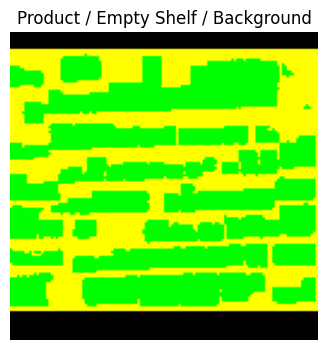

In [ ]:
viz = torch.zeros((*sem_prob.shape, 3), dtype=torch.float32)

# product → green
viz[product_mask] = torch.tensor([0.0, 1.0, 0.0], dtype=torch.float32)

# empty shelf → yellow
viz[empty_mask] = torch.tensor([1.0, 1.0, 0.0], dtype=torch.float32)

# background stays black

plt.figure(figsize=(6,4))
plt.imshow(viz)
plt.title("Product / Empty Shelf / Background")
plt.axis("off")
plt.show()
